In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

from keras.callbacks import Callback

import time

In [3]:
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
df = df.iloc[:, [0, 1, 2, 4, 3]]
df.head()

,Open,High,Low,Volume,Close
Date,,,,,
2006-01-03,47.47,47.85,46.25,7582127,47.58
2006-01-04,47.48,47.73,46.69,7440914,47.25
2006-01-05,47.16,48.20,47.11,5417258,47.65
2006-01-06,47.97,48.58,47.32,6154285,47.87
2006-01-09,46.55,47.10,46.40,8945056,47.08


## TRANSFORMERS

In [5]:
def create_sequences(df, target_col, exogenous_cols, sequence_length, step, scaler):
    sequences = []
    next_values = []
    for i in range(0, len(df) - sequence_length, step):
        seq = df[exogenous_cols + [target_col]].iloc[i : i + sequence_length].values
        # Scale the exogenous variables in the sequence
        seq[:, :-1] = scaler.transform(seq[:, :-1])
        label = df[target_col].iloc[i + sequence_length]
        sequences.append(seq)
        next_values.append(label)
    return np.array(sequences), np.array(next_values)

exogenous_columns = list(df.columns[:-1])
target_column = df.columns[-1]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[exogenous_columns].values)

sequence_length = 10
step = 1
X, y = create_sequences(df, target_column, exogenous_columns, sequence_length, step, scaler)
X.shape, y.shape

((3009, 10, 5), (3009,))

In [6]:
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split-10], X[split-10:], y[:split-10], y[split-10:]

In [7]:
def positional_encoding(seq_len, model_dim):
    angle_rads = get_angles(
        np.arange(seq_len)[:, np.newaxis],
        np.arange(model_dim)[np.newaxis, :],
        model_dim
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, model_dim):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(model_dim))
    return pos * angle_rates

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    seq_len, model_dim = inputs.shape[1], inputs.shape[2]

    pos_encoding = positional_encoding(seq_len, model_dim)
    inputs += pos_encoding[:, :seq_len, :]

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [8]:
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.25
mlp_dropout = 0.25

In [54]:
transformer_model = build_model(
    input_shape=(sequence_length, X_scaled.shape[1] + 1),
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout,
)

transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

transformer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10, 5)]              0         []                            
                                                                                                  
 tf.__operators__.add_24 (T  (None, 10, 5)                0         ['input_3[0][0]']             
 FOpLambda)                                                                                       
                                                                                                  
 layer_normalization_16 (La  (None, 10, 5)                10        ['tf.__operators__.add_24[0][0
 yerNormalization)                                                  ]']                           
                                                                                            

In [55]:
start = time.time()
history = transformer_model.fit(
    X_train,
    y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)
end = time.time()

Epoch 1/3
75/75 [==============================] - 13s 26ms/step - loss: 9006.5293 - val_loss: 38372.6250
Epoch 2/3
75/75 [==============================] - 1s 19ms/step - loss: 870.8149 - val_loss: 3474.3296
Epoch 3/3
75/75 [==============================] - 1s 19ms/step - loss: 451.9761 - val_loss: 1492.7123


In [11]:
y_pred = transformer_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5

mae = mean_absolute_error(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f'MAE: {mae}')
print(f'MAPE: {mape * 100:.2f}%')
print(f'R^2: {r2}')

20/20 [==============================] - 1s 5ms/step
RMSE: 44.51263465348824
MAE: 39.18570356979869
MAPE: 4.93%
R^2: 0.9396334258387739


In [12]:
elapsed_time = end - start
print(f"Time taken for LSTM: {elapsed_time} seconds")

Time taken for LSTM: 20.547741651535034 seconds


20/20 [==============================] - 0s 4ms/step


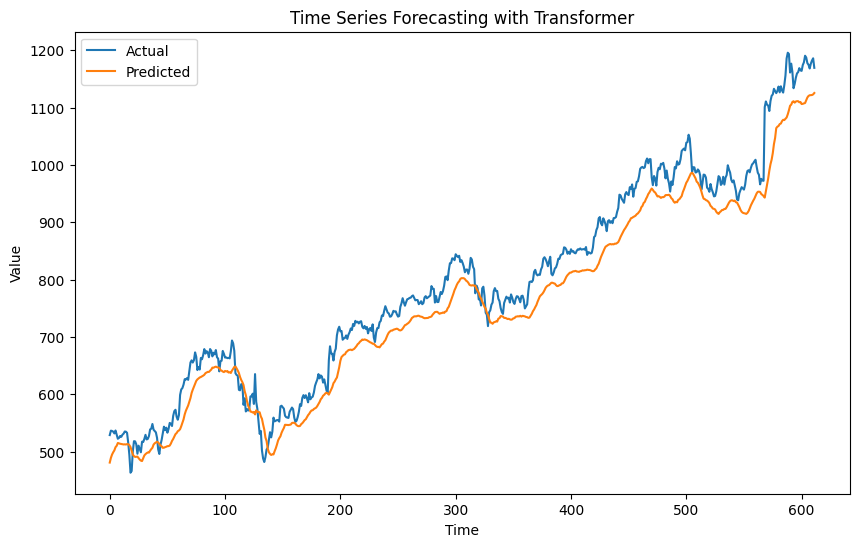

In [13]:
trainPred = transformer_model.predict(X_train)
testPred = transformer_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual")
plt.plot(testPred, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Forecasting with Transformer")
plt.legend()
plt.show()

In [14]:
result_df = pd.DataFrame(np.concatenate([trainPred, testPred], axis=0))
result_df.index = df.index[10:]

result_df.head()

,0
Date,
2006-01-18,39.376823
2006-01-19,38.963417
2006-01-20,38.642941
2006-01-23,38.208881
2006-01-24,37.741585


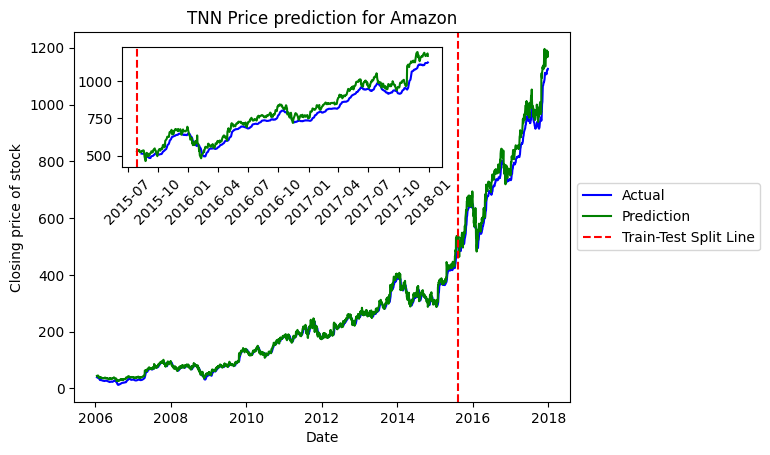

In [15]:
plt.plot(result_df, color = 'b')
plt.plot(df['Close'][10:], color='g')
plt.axvline(x=result_df.index[split - 1], color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Closing price of stock')
plt.title("TNN Price prediction for Amazon")
plt.legend(['Actual','Prediction', 'Train-Test Split Line'], loc='center left', bbox_to_anchor=(1, 0.5))

sub_axes = plt.axes([0.2, 0.6, .5, .25])
# plot the zoomed portion
sub_axes.plot(result_df.iloc[split:,], c = 'b')
sub_axes.plot(df['Close'].iloc[split:,], c = 'g')
sub_axes.axvline(x=result_df.index[split - 10], color='red', linestyle='--')
sub_axes.tick_params(axis='x', rotation=45)

plt.show()

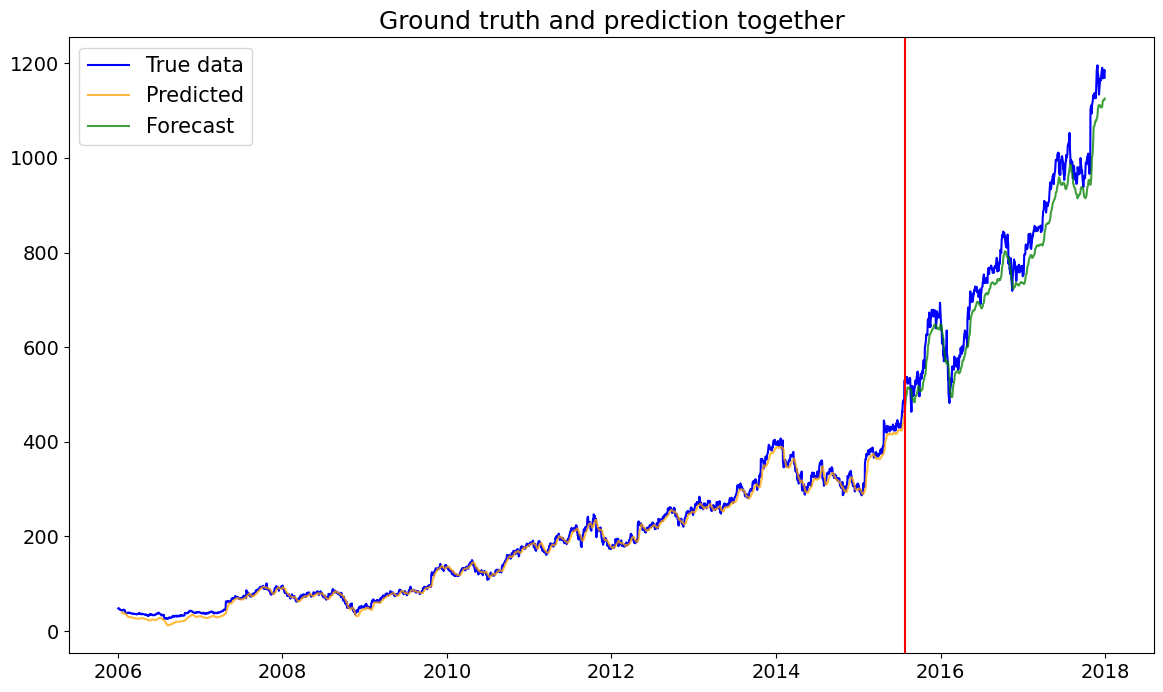

In [16]:
index = df.index.values
plt.figure(figsize=(14,8))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index, df.iloc[:, -1],c='blue')
plt.plot(index[10:split], trainPred, c='orange', alpha=0.75)
plt.plot(index[split:], testPred, c='green', alpha=0.75)
plt.legend(['True data','Predicted','Forecast'], fontsize=15)
plt.axvline(df.index[split], c="r")
#plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [17]:
start_point = X_test[-50]

predicted_values = []
current_input = start_point

for idx in range(-50, -1):
    current_input_reshaped = current_input.reshape((1, sequence_length, 5))

    next_value = transformer_model.predict(current_input_reshaped)

    predicted_values.append(next_value)
    next_test = X_test[idx+1][-1].reshape(1, -1)
    next_test[0, -1] = next_value

    current_input = np.concatenate([current_input[1:], next_test], axis=0)

predicted_values = np.array(predicted_values).squeeze()

1/1 [==============================] - 0s 19ms/step


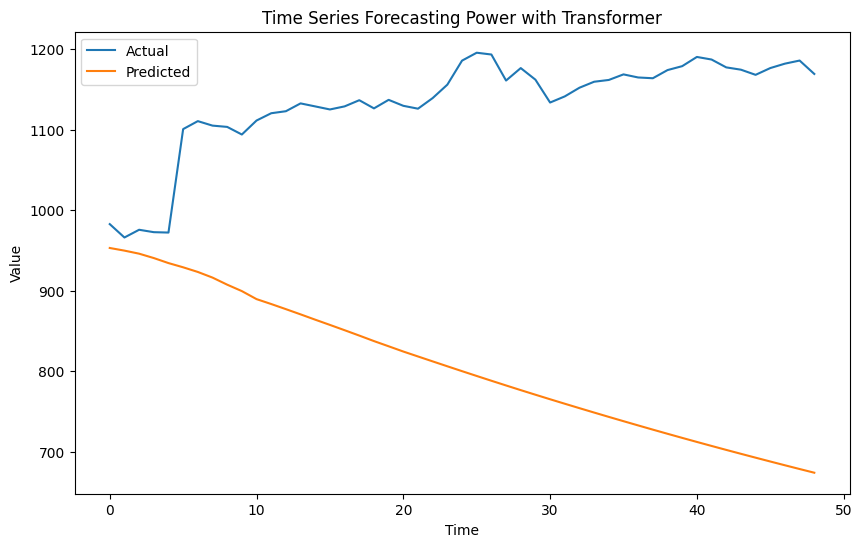

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[-49:], label="Actual")
plt.plot(predicted_values, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Forecasting Power with Transformer")
plt.legend()
plt.show()

In [56]:
def predict_steps_ahead(model, initial_sequence, steps_ahead, scaler):
    input_sequence = np.copy(initial_sequence)

    predictions = []
    for _ in range(steps_ahead):
        input_sequence[:, :-1] = scaler.transform(input_sequence[:, :-1])
        prediction = model.predict(np.expand_dims(input_sequence, axis=0))

        input_sequence[:, :-1] = np.roll(input_sequence[:, :-1], -1, axis=0)
        input_sequence[-1, -1] = prediction[0, -1]

        predictions.append(prediction[0, 0])

    return predictions

steps_list = [1, 5, 10, 15, 20]
for steps_ahead in steps_list:
    initial_sequence_index = -steps_ahead
    initial_sequence = X_test[initial_sequence_index]

    steps_ahead = steps_ahead

    predicted_values = predict_steps_ahead(transformer_model, initial_sequence, steps_ahead, scaler)
    rmse = mean_squared_error(y_test[-steps_ahead:], predicted_values) ** 0.5


    print(f"{steps_ahead} steps ahead predictions:", rmse)

1/1 [==============================] - 0s 394ms/step
1 steps ahead predictions: 41.68923828125003
1/1 [==============================] - 0s 20ms/step
5 steps ahead predictions: 46.570804920706614
1/1 [==============================] - 0s 20ms/step
10 steps ahead predictions: 68.25114658863794
1/1 [==============================] - 0s 20ms/step
15 steps ahead predictions: 53.35636041348472
1/1 [==============================] - 0s 20ms/step
20 steps ahead predictions: 55.07607406109649


## Hyperparameter Analysis

In [18]:
from itertools import product

sequence_length_list = [10, 90]
dropout_list = [0.0, 0.25]
num_heads_list = [2, 4, 8]
num_transformer_blocks_list = [2, 4]
lr_list = [0.1, 0.001]

hyperparameters = list(product(sequence_length_list, dropout_list, num_heads_list, num_transformer_blocks_list, lr_list))

error_train = []
error_test = []

for sequence_length, dout, num_heads, num_transformer_blocks, lr in hyperparameters:
    def create_sequences(df, target_col, exogenous_cols, sequence_length, step, scaler):
        sequences = []
        next_values = []
        for i in range(0, len(df) - sequence_length, step):
            seq = df[exogenous_cols + [target_col]].iloc[i : i + sequence_length].values
            # Scale the exogenous variables in the sequence
            seq[:, :-1] = scaler.transform(seq[:, :-1])
            label = df[target_col].iloc[i + sequence_length]
            sequences.append(seq)
            next_values.append(label)
        return np.array(sequences), np.array(next_values)

    exogenous_columns = list(df.columns[:-1])
    target_column = df.columns[-1]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[exogenous_columns].values)

    sequence_length = sequence_length
    step = 1
    X, y = create_sequences(df, target_column, exogenous_columns, sequence_length, step, scaler)

    split = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:split-sequence_length], X[split-sequence_length:], y[:split-sequence_length], y[split-sequence_length:]

    head_size = 256
    num_heads = num_heads
    ff_dim = 4
    num_transformer_blocks = num_transformer_blocks
    mlp_units = [128]
    dropout = dout
    mlp_dropout = dout

    transformer_model = build_model(
        input_shape=(sequence_length, X_scaled.shape[1] + 1),
        head_size=head_size,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_transformer_blocks=num_transformer_blocks,
        mlp_units=mlp_units,
        dropout=dropout,
        mlp_dropout=mlp_dropout,
    )

    transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")

    history = transformer_model.fit(
        X_train,
        y_train,
        epochs=3,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
    )

    ytr_pred = transformer_model.predict(X_train)
    yte_pred = transformer_model.predict(X_test)

    error_train.append(mean_absolute_percentage_error(y_train, ytr_pred))

    error_test.append(mean_absolute_percentage_error(y_test, yte_pred))

Epoch 1/3
75/75 [==============================] - 7s 14ms/step - loss: 36887.4336 - val_loss: 14664.0674
Epoch 2/3
75/75 [==============================] - 1s 10ms/step - loss: 163.1356 - val_loss: 965.4559
Epoch 3/3
20/20 [==============================] - 0s 3ms/step
Epoch 1/3
75/75 [==============================] - 7s 14ms/step - loss: 9564.8906 - val_loss: 19149.3242
Epoch 2/3
75/75 [==============================] - 1s 10ms/step - loss: 398.6759 - val_loss: 3590.9331
Epoch 3/3
20/20 [==============================] - 0s 3ms/step
Epoch 1/3
75/75 [==============================] - 11s 24ms/step - loss: 99880.9297 - val_loss: 627.3245
Epoch 2/3
75/75 [==============================] - 1s 18ms/step - loss: 209.2342 - val_loss: 674.1423
Epoch 3/3
20/20 [==============================] - 0s 4ms/step
Epoch 1/3
75/75 [==============================] - 12s 23ms/step - loss: 12668.9531 - val_loss: 34608.6172
Epoch 2/3
75/75 [==============================] - 1s 18ms/step - loss: 592.4396 

In [19]:
params = ['sq', 'dout', 'heads', 'blocks', 'lr', 'tr_error', 'te_error']
params_df = pd.DataFrame(hyperparameters)
params_df['train_error'] = error_train
params_df['test_error'] = error_test
params_df.columns = params

params_df

,sq,dout,heads,blocks,lr,tr_error,te_error
0,10,0.00,2,2,0.100,0.041194,0.019672
1,10,0.00,2,2,0.001,0.042378,0.025597
2,10,0.00,2,4,0.100,0.035639,0.021323
3,10,0.00,2,4,0.001,0.036313,0.025101
4,10,0.00,4,2,0.100,0.059043,0.039264
5,10,0.00,4,2,0.001,0.038451,0.022579
6,10,0.00,4,4,0.100,0.062785,0.042937
7,10,0.00,4,4,0.001,0.040180,0.026262
8,10,0.00,8,2,0.100,0.036140,0.021784
9,10,0.00,8,2,0.001,0.036408,0.022450
